<a href="https://colab.research.google.com/github/leehimcm/ml-project_Alzheimer-MRI-Disease-Classification/blob/main/ResNet50_hyein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet-50

In [ ]:
!pip3 install torch

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from datasets import load_dataset

from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
train_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
test_dataset = load_dataset('Falah/Alzheimer_MRI', split='test')

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Dataset class to apply transformations
class AlzheimerMRIDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Load image and label
        item = self.hf_dataset[idx]
        image = item["image"]
        label = item["label"]
        image = self.transform(image)  # Apply transformation

        return image, label

# Convert to PyTorch datasets
train_data = AlzheimerMRIDataset(train_dataset, transform)
test_data = AlzheimerMRIDataset(test_dataset, transform)

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

In [ ]:
# Set device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Adjust the output layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


In [ ]:
epochs = 15
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training accuracy
    train_accuracy = correct / total
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Test
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    epoch_labels = []
    epoch_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:  # Test data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            epoch_labels.extend(labels.cpu().numpy())
            epoch_preds.extend(predicted.cpu().numpy())

    # Calculate accuracy and loss
    test_accuracy = test_correct / test_total
    epoch_test_loss = test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/15, Train Loss: 0.6614, Train Accuracy: 0.7104
Test Loss: 0.5522, Test Accuracy: 0.7711
Epoch 2/15, Train Loss: 0.1828, Train Accuracy: 0.9322
Test Loss: 2.4481, Test Accuracy: 0.5055
Epoch 3/15, Train Loss: 0.0819, Train Accuracy: 0.9711
Test Loss: 0.5720, Test Accuracy: 0.8117
Epoch 4/15, Train Loss: 0.0754, Train Accuracy: 0.9719
Test Loss: 0.2609, Test Accuracy: 0.9156
Epoch 5/15, Train Loss: 0.0732, Train Accuracy: 0.9721
Test Loss: 0.4856, Test Accuracy: 0.8102
Epoch 6/15, Train Loss: 0.0301, Train Accuracy: 0.9898
Test Loss: 0.1874, Test Accuracy: 0.9422
Epoch 7/15, Train Loss: 0.0538, Train Accuracy: 0.9809
Test Loss: 0.2234, Test Accuracy: 0.9273
Epoch 8/15, Train Loss: 0.0333, Train Accuracy: 0.9898
Test Loss: 0.1426, Test Accuracy: 0.9555
Epoch 9/15, Train Loss: 0.0294, Train Accuracy: 0.9920
Test Loss: 0.1269, Test Accuracy: 0.9539
Epoch 10/15, Train Loss: 0.0396, Train Accuracy: 0.9855
Test Loss: 0.4759, Test Accuracy: 0.8516
Epoch 11/15, Train Loss: 0.0416, Train 

### Visualizations

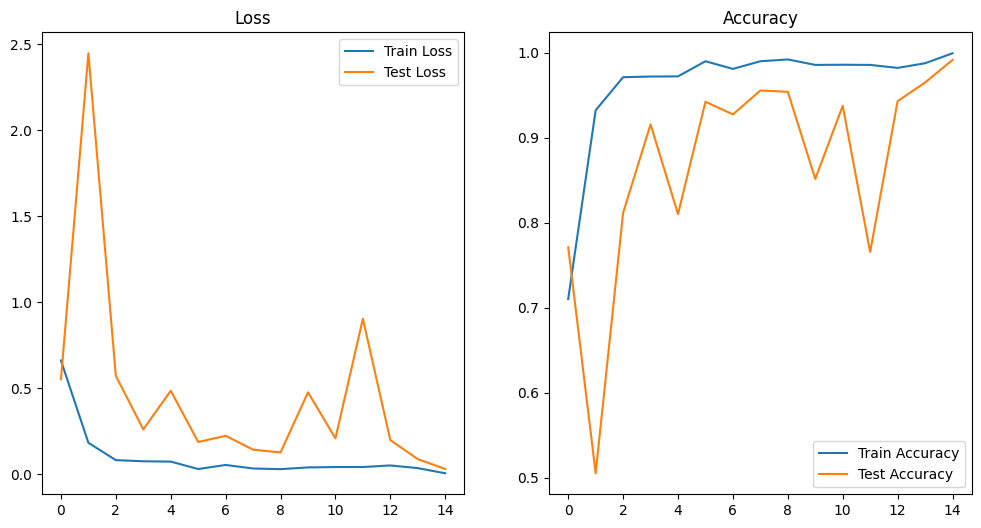

F1 Score: 0.9914
Accuracy: 0.9914


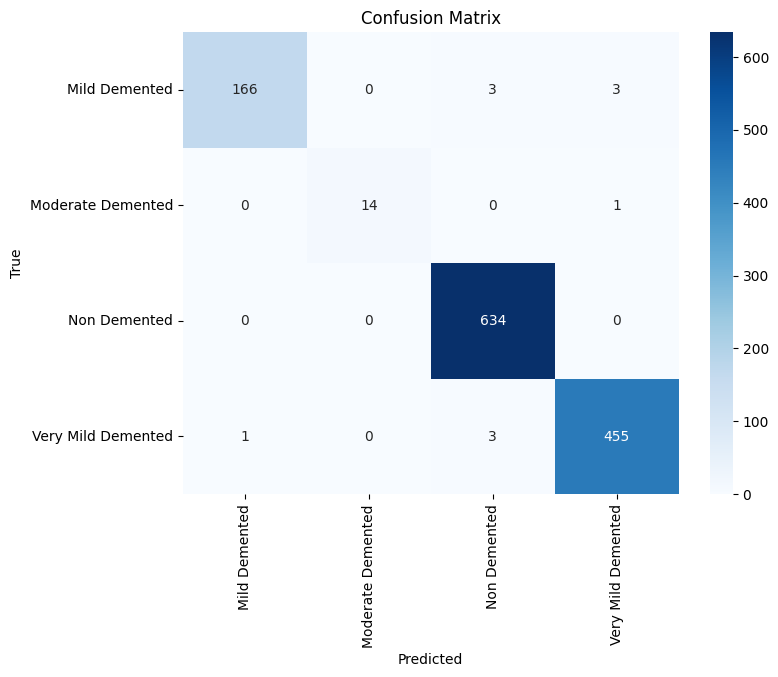

In [ ]:
# Plot Training and Test Loss/Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# F1 Score
f1 = f1_score(epoch_labels, epoch_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Accuracy
print(f"Accuracy: { test_accuracies[-1]:.4f}")

# Confusion Matrix
cm = confusion_matrix(epoch_labels, epoch_preds)

labels = ["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Label Distribution
from collections import Counter
import numpy as np

def plot_label_distribution(labels, preds, title):
    actual_counts = Counter(labels)
    predicted_counts = Counter(preds)
    all_classes = sorted(set(labels))
    actual_distribution = [actual_counts[cls] for cls in all_classes]
    predicted_distribution = [predicted_counts[cls] for cls in all_classes]

    plt.figure(figsize=(10, 6))
    bar_width = 0.4
    indices = np.arange(len(all_classes))
    plt.bar(indices, actual_distribution, width=bar_width, label="Actual Labels", alpha=0.7)
    plt.bar(indices + bar_width, predicted_distribution, width=bar_width, label="Predicted Labels", alpha=0.7)
    plt.title(title)
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.xticks(indices + bar_width / 2, all_classes)
    plt.legend()
    plt.grid(True)
    plt.show()


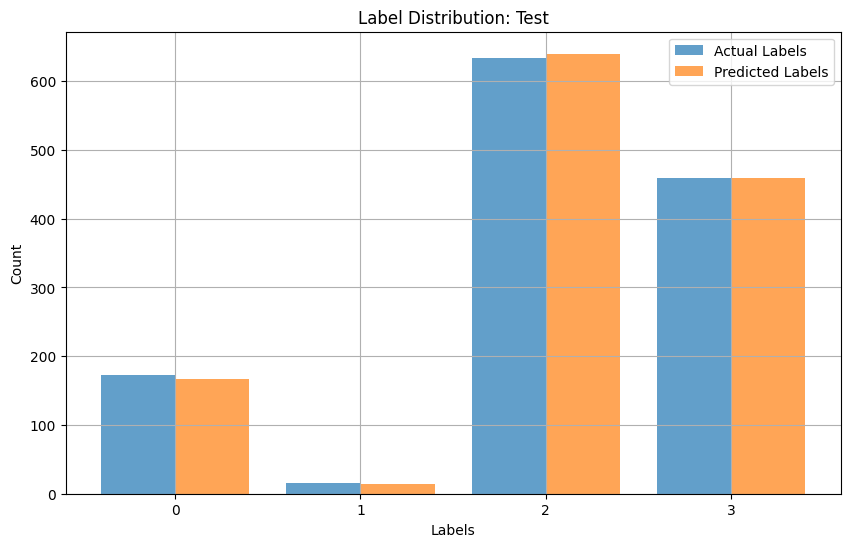

In [ ]:
# Test Label Distribution
plot_label_distribution(epoch_labels, epoch_preds, "Label Distribution: Test")

In [ ]:
# Upload new test images
import os
from google.colab import files
import numpy as np
from PIL import Image

test_images_path = '/content/test_images/'
os.makedirs(test_images_path, exist_ok=True)

uploaded = files.upload()

for filename in uploaded.keys():
    os.rename(filename, os.path.join(test_images_path, filename))

Saving img_normal.jpg to img_normal.jpg
Saving img_AD.jpg to img_AD.jpg


### Prediction on New Image

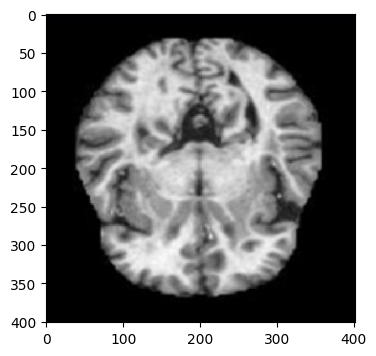

img_normal.jpg
Predicted class: Non Demented




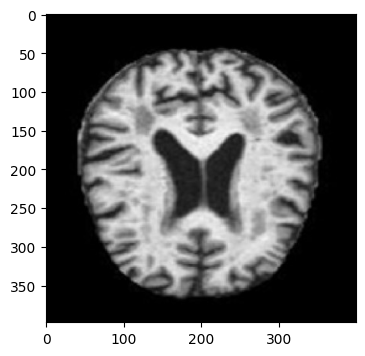

img_AD.jpg
Predicted class: Very Mild Demented




In [ ]:
# Mapping class indices to labels
class_labels = {0: 'Mild Demented', 1: 'Moderate Demented', 2: 'Non Demented', 3: 'Very Mild Demented'}

# Process each image in the test directory
for filename in os.listdir(test_images_path):
    if filename.lower().endswith(('png', 'jpg', 'jpeg')):
        img_path = os.path.join(test_images_path, filename)
        img = Image.open(img_path)

        # Apply transformations and move the tensor to the device
        input_tensor = transform(img)
        input_batch = input_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            # Perform model inference
            output = model(input_batch)

        # Get predicted class
        _, predicted_class = torch.max(output, 1)

        # Display image and predicted class
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.show()
        print(f"{filename}")
        print(f"Predicted class: {class_labels[predicted_class.item()]}\n\n")
